In [9]:
!cd /content/drive/MyDrive


In [10]:
!pwd

/content


In [11]:
!pip3 install tensorflow

In [12]:
!pip3 install keras

In [15]:
import sys
# Append the directory to your python path using sys
sys.path.append('/content/drive/MyDrive/Image Styling')
# Import the module
import model_func

In [16]:
#!cp /content/drive/MyDrive/Image_Styling/ /content/ -r

In [17]:
#!pwd

In [18]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import numpy as np

In [19]:

from tensorflow import keras
from keras.applications import vgg16
from tensorflow import keras
from keras import backend as K
from keras.regularizers import Regularizer
from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model,Sequential
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from model_func import InputNormalize,VGGNormalize,ReflectionPadding2D,Denormalize,conv_bn_relu,res_conv,dconv_bn_nolinear
import time



In [24]:
img = cv2.imread('/content/drive/MyDrive/Image_Styling/data/content_image1.png')
(height, width, channels) = img.shape
img_rows = 400
img_cols = int(width * img_rows / height)
result_prefix = "neural_style_transfer_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 5e-6
content_weight = 1e-8

Text(0.5, 1.0, 'Content Image')

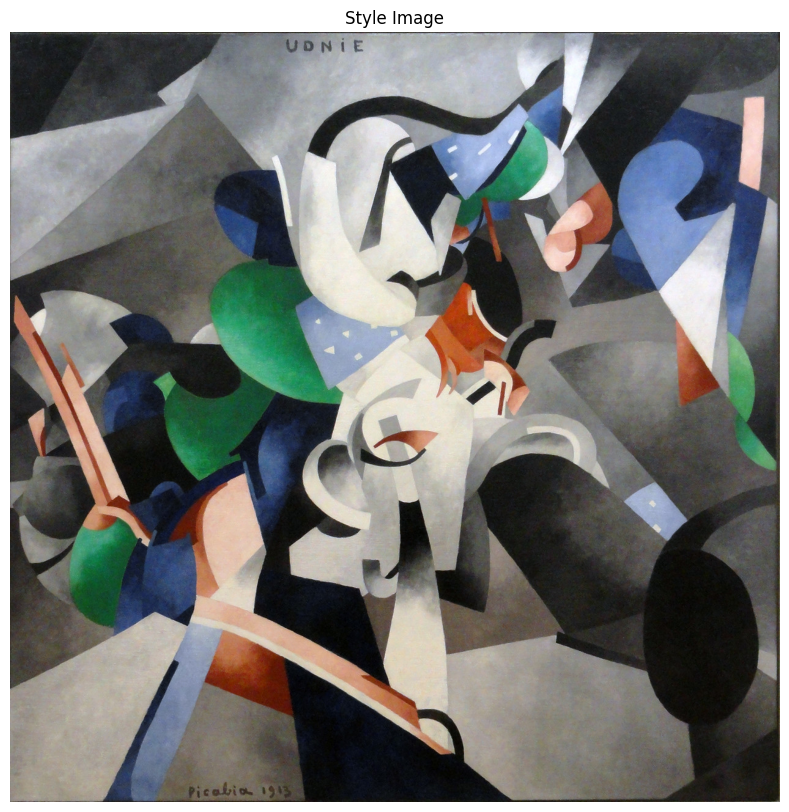

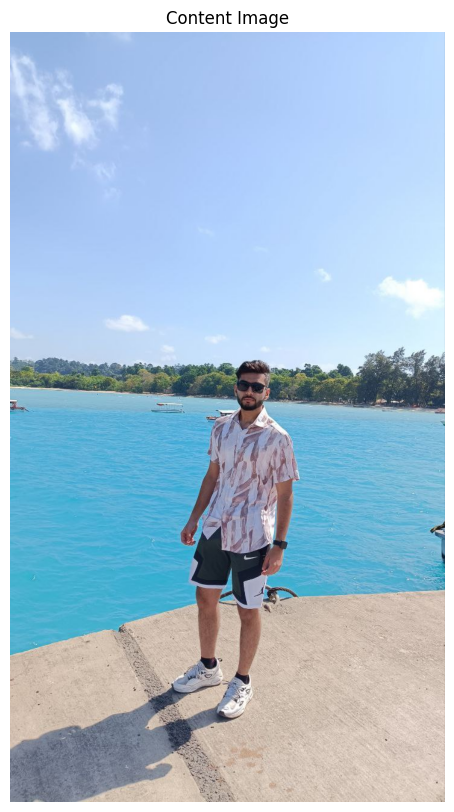

In [25]:
figure = plt.figure(figsize=(10, 10))
style_img = cv2.imread('/content/drive/MyDrive/Image_Styling/data/style_image3.jpg')
style_img = cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB)
plt.imshow(style_img)
plt.axis('off')
plt.title('Style Image')

figure2 = plt.figure(figsize=(10, 10))
content_img = cv2.imread('/content/drive/MyDrive/Image_Styling/data/content_image1.png')
content_img = cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)
plt.imshow(content_img)
plt.axis('off')
plt.title('Content Image')

In [26]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (img_cols, img_rows))
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    image = vgg16.preprocess_input(image)
    return image


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_rows, img_cols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [27]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [28]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_rows * img_cols
    return tf.reduce_sum(tf.square(S - C)) / (channels * (3 ** 2) * (size ** 2))

In [29]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [30]:
def total_variation_loss(x):
    a = tf.square(x[:, : img_rows - 1, : img_cols - 1, :] - x[:, 1:, : img_cols - 1, :])
    b = tf.square(x[:, : img_rows - 1, : img_cols - 1, :] - x[:, : img_rows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [31]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg16.VGG16(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

58889256/58889256 [==============================] - 0s 0us/step


In [32]:
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [33]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [34]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [35]:
# optimizer = keras.optimizers.Adam(
#     keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=1000.0, decay_steps=1000, decay_rate=0.96
#     )
# )
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=500, decay_rate=0.96
    )
)

base_image = preprocess_image('/content/drive/MyDrive/Image_Styling/data/content_image1.png')
style_reference_image = preprocess_image('/content/drive/MyDrive/Image_Styling/data/style_image3.jpg')
combination_image = tf.Variable(preprocess_image('/content/drive/MyDrive/Image_Styling/data/content_image1.png'))
print(base_image.shape)
print(style_reference_image.shape)
print(combination_image.shape)
losses = []
iter = []
# combination_image = tf.Variable(content_img)

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    losses.append(loss)
    iter.append(i)
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
    if i == 4000:
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
#         keras.preprocessing.image.save_img(fname, img)
        cv2.imwrite(fname, img)

(1, 400, 225, 3)
(1, 400, 225, 3)
(1, 400, 225, 3)
Iteration 100: loss=15340.51
Iteration 200: loss=6832.54
Iteration 300: loss=5679.69
Iteration 400: loss=3714.95
Iteration 500: loss=15524.98
Iteration 600: loss=3004.25
Iteration 700: loss=2762.01
Iteration 800: loss=2591.20
Iteration 900: loss=2673.52
Iteration 1000: loss=2460.01
Iteration 1100: loss=2295.70
Iteration 1200: loss=2503.19
Iteration 1300: loss=2201.94
Iteration 1400: loss=2118.23
Iteration 1500: loss=2083.86
Iteration 1600: loss=2116.47
Iteration 1700: loss=1999.89
Iteration 1800: loss=1941.07
Iteration 1900: loss=1961.09
Iteration 2000: loss=1897.93
Iteration 2100: loss=1857.81
Iteration 2200: loss=1869.15
Iteration 2300: loss=1812.42
Iteration 2400: loss=1799.55
Iteration 2500: loss=1784.76
Iteration 2600: loss=1751.63
Iteration 2700: loss=1748.78
Iteration 2800: loss=1721.27
Iteration 2900: loss=1703.16
Iteration 3000: loss=1693.42
Iteration 3100: loss=1676.60
Iteration 3200: loss=1658.47
Iteration 3300: loss=1648.04

Text(0.5, 1.0, 'Content Image')

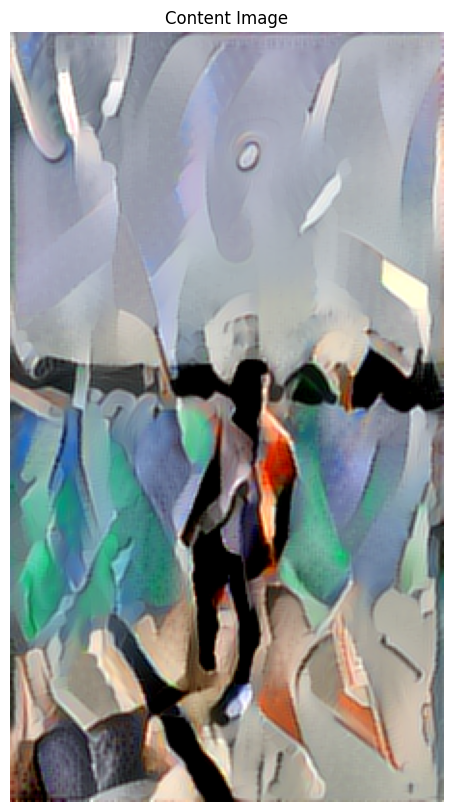

In [36]:
figure2 = plt.figure(figsize=(10, 10))
content_img = cv2.imread('neural_style_transfer_generated_at_iteration_4000.png')
content_img = cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)
plt.imshow(content_img)
plt.axis('off')
plt.title('Content Image')

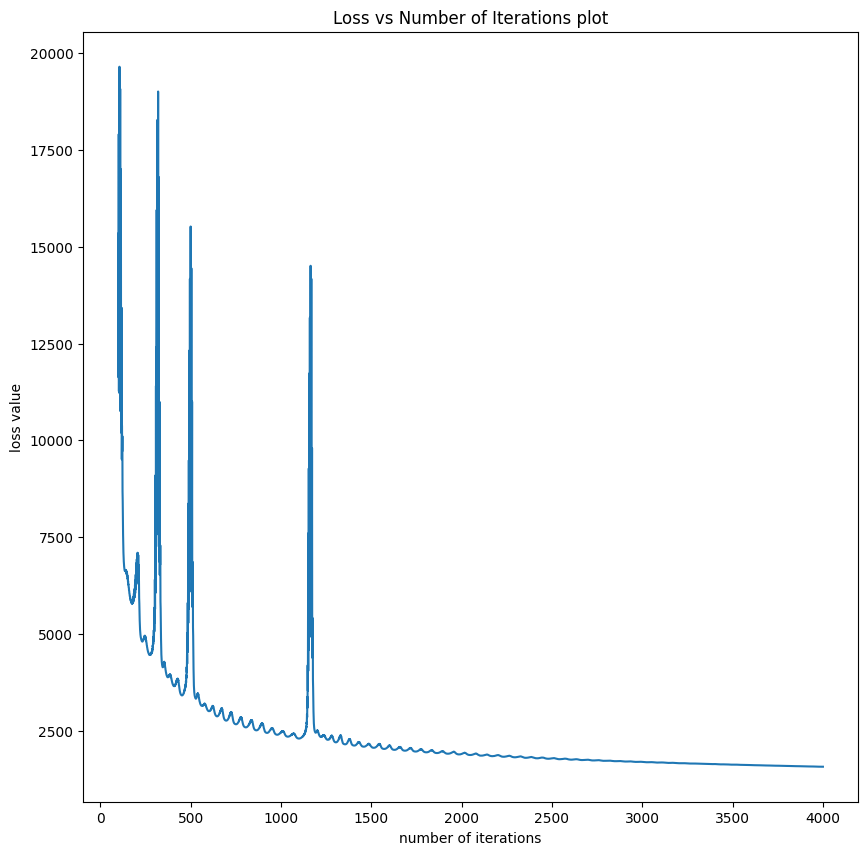

In [38]:
iter = [i for i in range(100, 4001)]
figure = plt.figure(figsize=(10, 10))
plt.plot(iter, losses[99:])
plt.xlabel('number of iterations')
plt.ylabel('loss value')
plt.title('Loss vs Number of Iterations plot')
plt.show()

**Using Pre-Trained PyTroch models for the Udnie Style Image for stylizing the Input Image**

In [53]:
model = cv2.dnn.readNetFromTorch('/content/drive/MyDrive/Image_Styling/data/udnie.t7')

image = cv2.imread('/content/drive/MyDrive/Image_Styling/data/content_image1.png')

(h, w) = image.shape[:2]
image = cv2.resize(image, (600, h))
(h, w, c) = image.shape
print(h, w, c)

1280 600 3


In [54]:
blob = cv2.dnn.blobFromImage(image, 1.0, (w, h), (103.939, 116.779, 123.680), swapRB=False, crop=False)

model.setInput(blob)
output = model.forward()
output = output.reshape((3, output.shape[2], output.shape[3]))
output[0] += 103.939
output[1] += 116.779
output[2] += 123.680
output /= 255.0
output = output.transpose(1, 2, 0)

(-0.5, 599.5, 1279.5, -0.5)

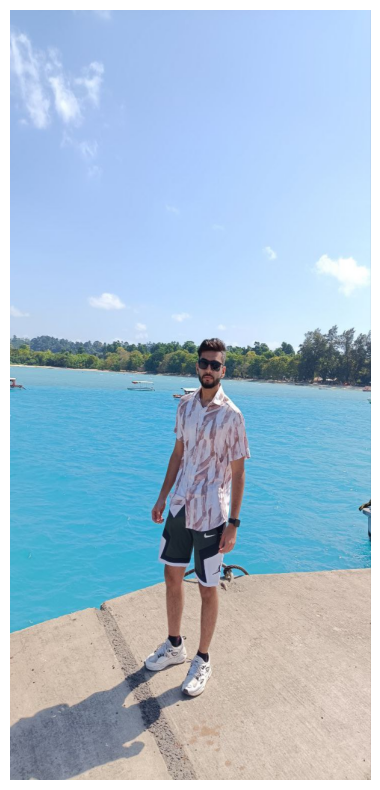

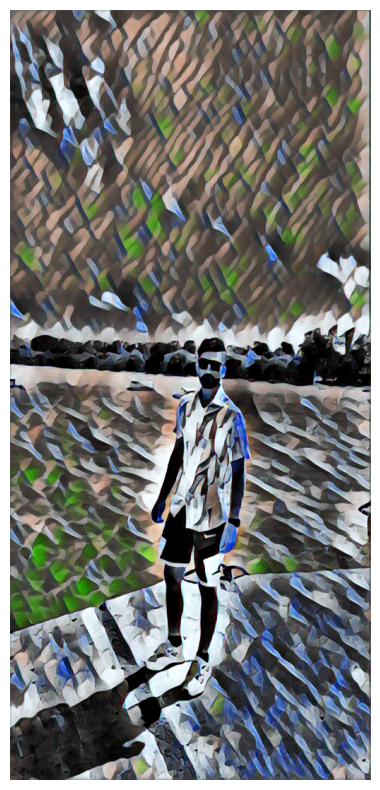

In [55]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
figure = plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')

figure2 = plt.figure(figsize=(10, 10))
plt.imshow(output)
plt.axis('off')

In [39]:
# def preprocess_image(image_path, image_width, image_height):
#     image = cv2.imread(image_path)
#     image = cv2.resize(image, (image_width, image_height))
#     image = np.array(image)
#     image = np.expand_dims(image, axis=0)
# #     image = vgg16.preprocess_input(image)
#     return image


# def deprocess_image(x):
#     # Util function to convert a tensor into a valid image
#     x = x.reshape((img_rows, img_cols, 3))
#     # Remove zero-center by mean pixel
#     x[:, :, 0] += 103.939
#     x[:, :, 1] += 116.779
#     x[:, :, 2] += 123.68
#     # 'BGR'->'RGB'
#     x = x[:, :, ::-1]
#     x = np.clip(x, 0, 255).astype("uint8")
#     return x

In [40]:
# dummy_loss_value = K.variable(0.0)
# def dummy_loss(y_true, y_pred):
#     return dummy_loss_value

In [41]:
# @tf.function
# def compute_loss_and_grads(y_true, y_pred):
#     with tf.GradientTape() as tape:
#         loss = dummy_loss(y_true, y_pred)
#     grads = tape.gradient(loss, y_pred)
#     return loss, grads

In [42]:
# def gram_matrix(x):
#     x = tf.transpose(x, (2, 0, 1))
#     features = tf.reshape(x, (tf.shape(x)[0], -1))
#     gram = tf.matmul(features, tf.transpose(features))
#     return gram


In [43]:
# class StyleReconstructionRegularizer(Regularizer):

#     def __init__(self, style_feature_target, weight=1.0):
#         self.style_feature_target = style_feature_target
#         self.weight = weight
#         self.uses_learning_phase = False
#         super(StyleReconstructionRegularizer, self).__init__()

#         self.style_gram = gram_matrix(style_feature_target)

#     def __call__(self, x):
#         output = x.output[0]
#         loss = self.weight *  K.sum(K.mean(K.square((self.style_gram-gram_matrix(output) ))))

#         return loss


# class FeatureReconstructionRegularizer(Regularizer):

#     def __init__(self, weight=1.0):
#         self.weight = weight
#         self.uses_learning_phase = False
#         super(FeatureReconstructionRegularizer, self).__init__()

#     def __call__(self, x):
#         generated = x.output[0]
#         content = x.output[1]

#         loss = self.weight *  K.sum(K.mean(K.square(content-generated)))
#         return loss


# class TVRegularizer(Regularizer):
#     """ Enforces smoothness in image output. """

#     def __init__(self, weight=1.0):
#         self.weight = weight
#         self.uses_learning_phase = False
#         super(TVRegularizer, self).__init__()

#     def __call__(self, x):
#         assert K.ndim(x.output) == 4
#         x_out = x.output

#         shape = K.shape(x_out)
#         img_width, img_height,channel = (shape[1],shape[2], shape[3])
#         size = img_width * img_height * channel
#         if K.image_data_format() == 'th':
#             a = K.square(x_out[:, :, :img_width - 1, :img_height - 1] - x_out[:, :, 1:, :img_height - 1])
#             b = K.square(x_out[:, :, :img_width - 1, :img_height - 1] - x_out[:, :, :img_width - 1, 1:])
#         else:
#             a = K.square(x_out[:, :img_width - 1, :img_height - 1, :] - x_out[:, 1:, :img_height - 1, :])
#             b = K.square(x_out[:, :img_width - 1, :img_height - 1, :] - x_out[:, :img_width - 1, 1:, :])
#         loss = self.weight * K.sum(K.pow(a + b, 1.25))
#         return loss

In [44]:
# def image_transform_net(img_width,img_height,tv_weight=1):
#     x = Input(shape=(img_width,img_height,3))
#     a = InputNormalize()(x)
#     a = ReflectionPadding2D(padding=(40,40),input_shape=(img_width,img_height,3))(a)
#     a = conv_bn_relu(32, 9, 9, stride=(1,1))(a)
#     a = conv_bn_relu(64, 9, 9, stride=(2,2))(a)
#     a = conv_bn_relu(128, 3, 3, stride=(2,2))(a)
#     for i in range(5):
#         a = res_conv(128,3,3)(a)
#     a = dconv_bn_nolinear(64,3,3)(a)
#     a = dconv_bn_nolinear(32,3,3)(a)
#     a = dconv_bn_nolinear(3,9,9,stride=(1,1),activation="tanh")(a)
#     # Scale output to range [0, 255] via custom Denormalize layer
#     y = Denormalize(name='transform_output')(a)

#     model = Model(inputs=x, outputs=y)

#     if tv_weight > 0:
#         add_total_variation_loss(model.layers[-1],tv_weight)
# #         add_total_variation_loss(y, tv_weight)

#     return model, x, y
# #     return x, y

In [51]:
# def loss_net(x_in, trux_x_in,width, height,style_image_path,content_weight,style_weight):
#     # Append the initial input to the FastNet input to the VGG inputs
#     x = concatenate([x_in, trux_x_in], axis=0)

#     # Normalize the inputs via custom VGG Normalization layer
#     x = VGGNormalize(name="vgg_normalize")(x)

#     vgg = vgg16.VGG16(include_top=False, weights=None, input_tensor=x)
#     vgg.load_weights('/content/drive/MyDrive/Image_Styling/data/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
#     vgg.summary()

#     vgg_output_dict = dict([(layer.name, layer.output) for layer in vgg.layers[-18:]])
#     vgg_layers = dict([(layer.name, layer) for layer in vgg.layers[-18:]])

#     if style_weight > 0:
#         add_style_loss(vgg,style_image_path , vgg_layers, vgg_output_dict, width, height,style_weight)

#     if content_weight > 0:
#         add_content_loss(vgg_layers,vgg_output_dict,content_weight)

#     # Freeze all VGG layers
#     for layer in vgg.layers[-19:]:
#         layer.trainable = False

#     return vgg

In [46]:
# def add_style_loss(vgg,style_image_path,vgg_layers,vgg_output_dict,img_width, img_height,weight):
#     style_img = preprocess_image(style_image_path, img_width, img_height)
#     print('Getting style features from VGG network.')

#     style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']

#     style_layer_outputs = []

#     for layer in style_layers:
#         style_layer_outputs.append(vgg_output_dict[layer])
#     print(style_layer_outputs)
#     print(vgg.layers[-20].input)

#     vgg_style_func = K.function([vgg.input], style_layer_outputs)

#     style_features = vgg_style_func([style_img])

#     # Style Reconstruction Loss
#     for i, layer_name in enumerate(style_layers):
#         layer = vgg_layers[layer_name]

#         feature_var = K.variable(value=style_features[i][0])
#         style_loss = StyleReconstructionRegularizer(
#                             style_feature_target=feature_var,
#                             weight=weight)(layer)

#         layer.add_loss(style_loss)

In [47]:
# def add_content_loss(vgg_layers,vgg_output_dict,weight):
#     # Feature Reconstruction Loss
#     content_layer = 'block3_conv3'
#     content_layer_output = vgg_output_dict[content_layer]

#     layer = vgg_layers[content_layer]
#     content_regularizer = FeatureReconstructionRegularizer(weight)(layer)
#     layer.add_loss(content_regularizer)

In [48]:
# def add_total_variation_loss(transform_output_layer,weight):
#     # Total Variation Regularization
#     layer = transform_output_layer  # Output layer
#     tv_regularizer = TVRegularizer(weight)(layer)
#     layer.add_loss(tv_regularizer)

In [52]:
# style_weight = 4.0
# content_weight = 1.0
# tv_weight = 1e-6
# img_width = img_height = 64
# style_image_path = '/content/drive/MyDrive/Image_Styling/data/style_image2.jpg'

# net, input_itn, output_itn = image_transform_net(img_width, img_height, tv_weight)
# # x = Input(shape=(img_width, img_height, 3))
# model = loss_net(output_itn, input_itn, img_width, img_height, style_image_path, content_weight, style_weight)

Model: "vgg16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_normalize_2 (InputNo  (None, 64, 64, 3)            0         ['input_4[0][0]']             
 rmalize)                                                                                         
                                                                                                  
 reflection_padding2d_8 (Re  (None, 144, 144, 3)          0         ['input_normalize_2[0][0]']   
 flectionPadding2D)                                                                               
                                                                                              